<a href="https://colab.research.google.com/github/prekshya-dawadi/GDLLabs/blob/main/Nepal_AI_GNNs_notebook_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geometric Deep Learning at Nepal AI School (GNN Notebook)

Notebook by **Federico Monti**, contact: federico.monti@usi.ch

We recommend running this notebook online on Google Colab which offers free GPU access: Click on Runtime -> Change runtime type -> Select a GPU option (T4 is okay)

*All imports should work on Google Colab, if you want to run this locally on your machine you may need to work out package installations.*

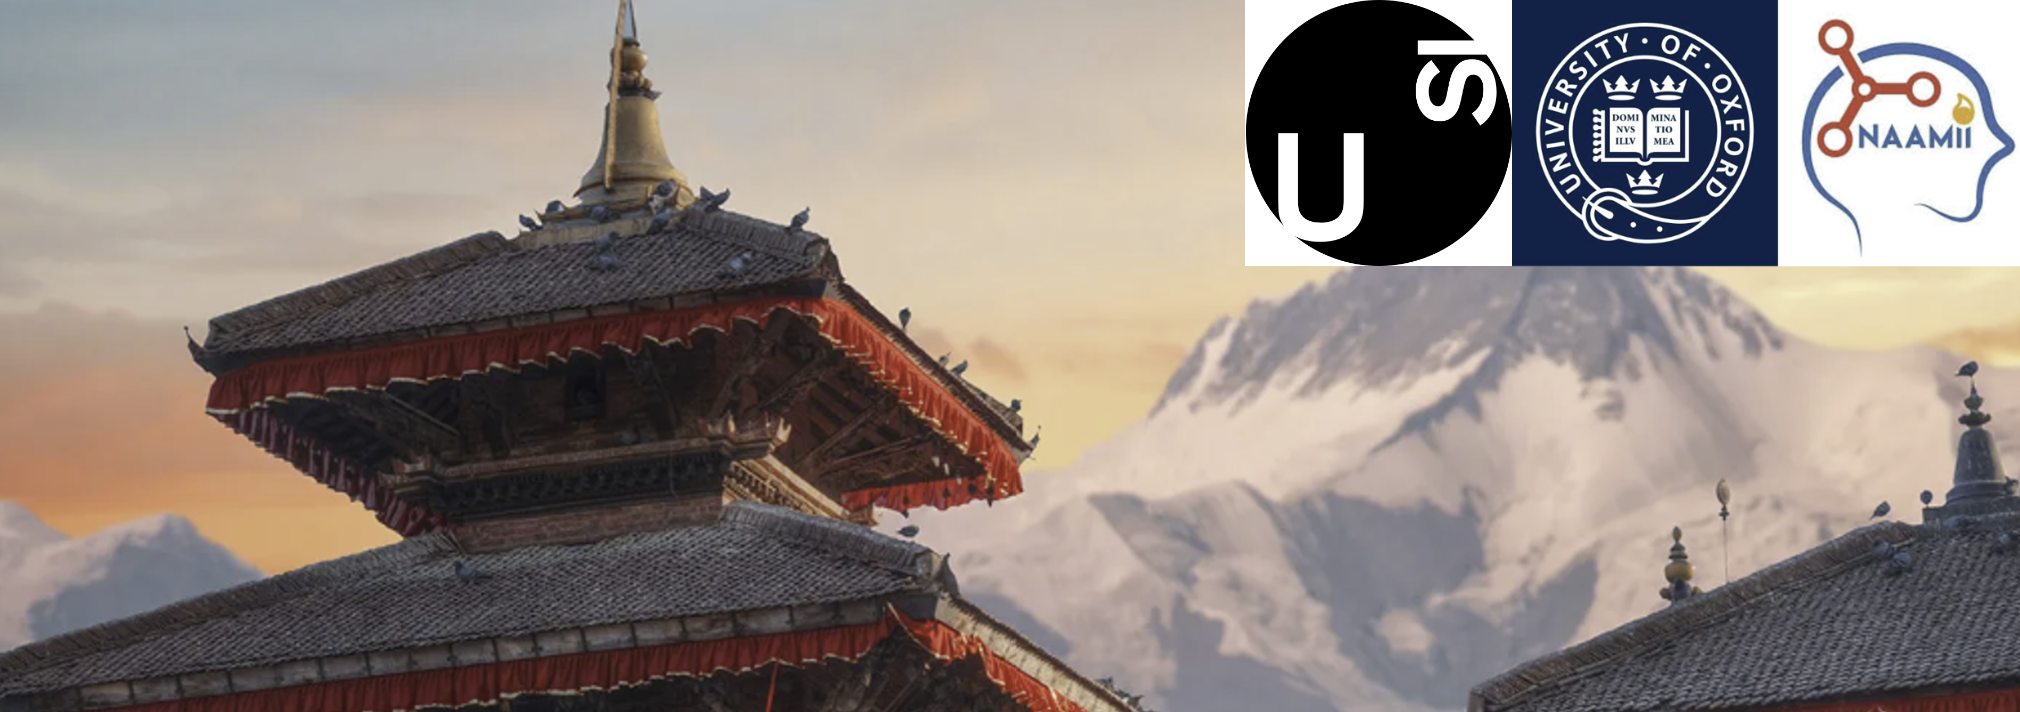

## Section 1: Introduction

As we have seen in the introductory notebook, most GNNs can be classified into three main categories dependently on the way they propagate information on a provided graph:



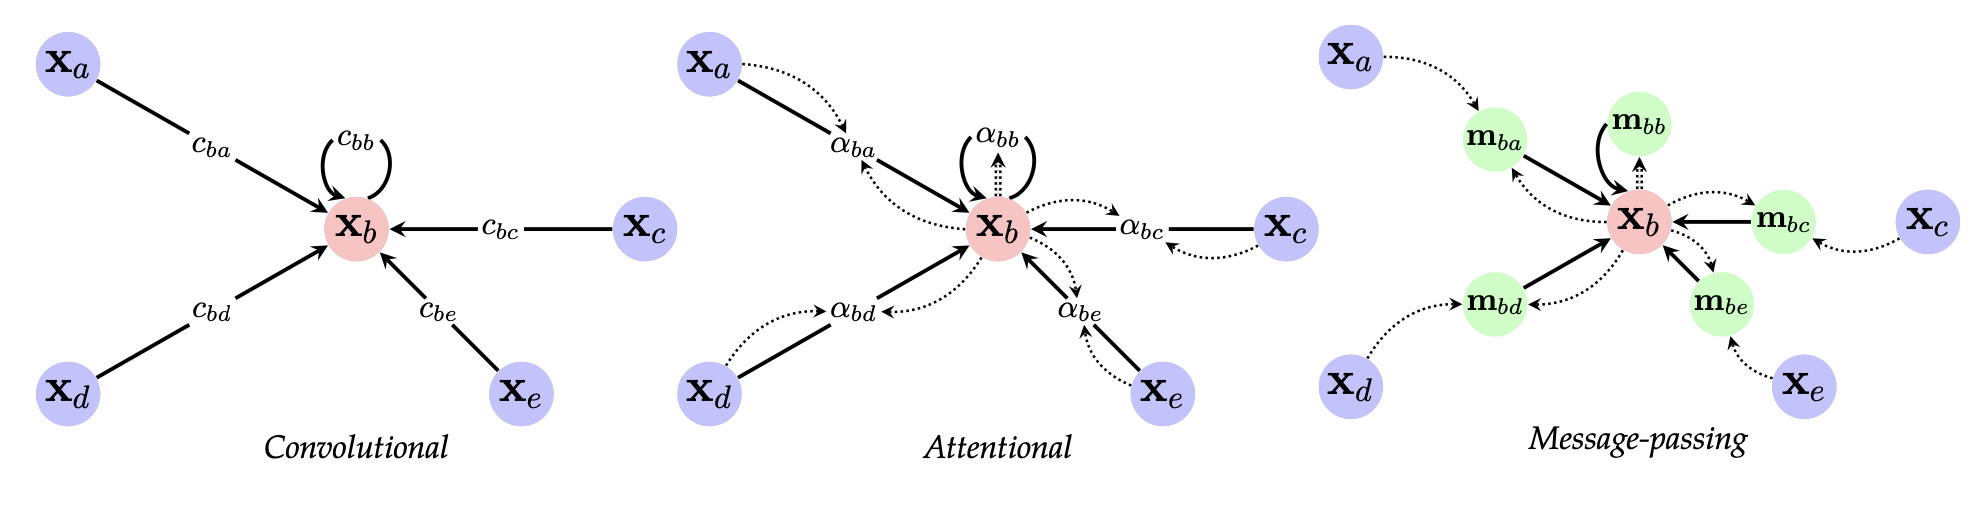

The diffusion layer (i.e. the layer that updates node representations by exchanging information across neighbors) operates in this case as a shared permutation-invariant function $\phi(\mathbf{h}_i, \mathbf{H}_{N_i})$, which takes in input the features $\mathbf{h}_i$ of target node $i$, the ones of its neighbors $\mathbf{H}_{N_i}$, and outputs a new embedding for $i$ dependently on the value of $\mathbf{h}_i$ and $\mathbf{H}_{N_i}$. In this notebook, we are going to explore three different diffusion layers: GCN (https://arxiv.org/abs/1609.02907), GAT (https://arxiv.org/abs/1710.10903), and MPNN (https://arxiv.org/abs/1704.01212); one for each class outlined above. We will often rely on `PyTorch Geometric` (PyG) for implementation, but we will also implement our own classes of diffusion layers, so that you'll build an understanding on how PyG works under the hood.

## Section 2: Graph Convolutional Networks

The first diffusion layer we focus on is the one introduced by Kipf&Welling in 2016 (https://arxiv.org/abs/1609.02907), and (as we have seen in the introductory notebook) architectures implemented with only this layer are generally reffered to as Graph Convolutional Networks (GCNs). As we did in the intoductory notebook, we are gonna apply GCNs on the CORA dataset, which is a citation network where nodes are documents and edges are citations among them. To refresh our memory, GCNs refine the node features of a given graph according to the following equation:

$$
\mathbf{\tilde{H}} = \sigma \big( \mathbf{\tilde{D}}^{-\frac{1}{2}} \mathbf{\tilde{A}} \mathbf{\tilde{D}}^{-\frac{1}{2}} \mathbf{H} \mathbf{W}\big);
$$

where $\mathbf{A}$ is the adjacency matrix, $\mathbf{\tilde{A}} = \mathbf{A} + \mathbf{I}$, $\mathbf{\tilde{D}}$ is the degree matrix of $\mathbf{\tilde{A}}$ ($\mathbf{\tilde{D}}_{ii} = \sum_{j = 1}^{n} \mathbf{\tilde{A}}_{ij}$ and $\mathbf{\tilde{D}}_{ij} = 0$ if $j \neq i$), and $\sigma(.)$ is a non-linearity (e.g. ReLU). In the experiments of the introductory notebook we implemented such architectures using a couple of layers, and we observed how the model was actually able to predict quite well the class associated to each document in our citation network. Let's revise our PyG implementation to bring us up to speed.




### GCN implementation on CORA

In [12]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

2.5.1+cu121


In [ ]:
# Download the corresponding PyTorch Geometric module
%%capture
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=2.4.0+cu121
"""
%env TORCH=2.4.0+cu121
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

# Download some utilities for nicely plotting graphs with networkx
!apt install libgraphviz-dev
!pip install pygraphviz

In [ ]:
import torch
import torch.nn.functional as F
import torch_scatter
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from torch_geometric.utils import to_dense_adj

In [ ]:
# Specify device --> Run on GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function for computing accuracy
def compute_accuracy(pred_y, y):
    correct = (pred_y == y).sum().item()
    acc = correct / len(y)
    return acc

In [ ]:
dataset = Planetoid(root='tmp/Cora', name='Cora')

print("Number of graphs: ", len(dataset))
print("Number of features: ", dataset.num_features)
print("Number of classes: ", dataset.num_classes)

# select the first graph
data = dataset[0]

print("\nNumber of nodes: ", data.num_nodes)
print("Number of edges: ", data.num_edges)
print("Is directed: ", data.is_directed())

print("\nNumber of training nodes", dataset.train_mask.sum().numpy())
print("Number of validation nodes", dataset.val_mask.sum().numpy())
print("Number of test nodes", dataset.test_mask.sum().numpy())

Processing...


Number of graphs:  1
Number of features:  1433
Number of classes:  7

Number of nodes:  2708
Number of edges:  10556
Is directed:  False

Number of training nodes 140
Number of validation nodes 500
Number of test nodes 1000


Done!


In [ ]:
# Prepare your data
data = data.to(device)
num_features = data.num_features
num_classes = dataset.num_classes  # Ensure dataset provides num_classes

In [ ]:
# Class implementing our GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_input_features, list_num_hidden_features, num_classes, dropout_p=0.7, non_linearity=lambda x: F.relu(x)):
        super().__init__()
        self.dropout_p = dropout_p
        self.conv_layers = []
        for idx_layer, num_hidden_features in enumerate(list_num_hidden_features):
          if idx_layer == 0:
            self.conv_layers.append(GCNConv(num_input_features,
                                            num_hidden_features))
          else:
            self.conv_layers.append(GCNConv(list_num_hidden_features[idx_layer-1],
                                            list_num_hidden_features[idx_layer]))
        self.conv_layers.append(GCNConv(list_num_hidden_features[-1],
                                        num_classes))
        self.conv_layers = torch.nn.ModuleList(self.conv_layers)
        self.non_linearity = non_linearity

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for idx_layer, conv_layer in enumerate(self.conv_layers):
          x = F.dropout(x, training=self.training, p=self.dropout_p)
          x = conv_layer(x, edge_index)
          if idx_layer < len(self.conv_layers)-1:
            x = self.non_linearity(x)

        return x

In [ ]:
def train_and_eval_single_graph(model, data, optimizer, criterion, num_epochs, verbose=True):
  # Training loop
  losses = []
  train_accuracies = []
  val_accuracies = []
  test_accuracies = []
  for epoch in range(num_epochs):
      ############### Training step ###############

      # Clean gradients
      optimizer.zero_grad()

      # Forward pass with dropout
      model.train()
      out = model(data)

      # Compute loss function based on cross-entropy
      loss = criterion(out[data.train_mask], data.y[data.train_mask])

      # Backpropagation step
      loss.backward()
      optimizer.step()

      ############### Model evaluation after training step ###############

      # Forward pass without dropout
      model.eval()
      out = model(data)
      softmax_out = F.softmax(out, dim=1)
      pred_y = softmax_out.argmax(dim=1)

      # Compute accuracy on training, validation and test set
      train_acc = compute_accuracy(pred_y[data.train_mask],
                                  data.y[data.train_mask])
      val_acc = compute_accuracy(pred_y[data.val_mask],
                                data.y[data.val_mask])
      test_acc = compute_accuracy(pred_y[data.test_mask],
                                  data.y[data.test_mask])

      losses.append(loss.item())
      train_accuracies.append(train_acc)
      val_accuracies.append(val_acc)
      test_accuracies.append(test_acc)

      if (epoch+1) % 2 == 0 and verbose:
          print('Epoch: {}, Loss: {:.4f}, Training Acc: {:.4f}, Validation Acc: {:.4f}'.format(epoch+1, loss.item(), train_acc, val_acc))

  return losses, train_accuracies, val_accuracies, test_accuracies

In [ ]:
# Specify training parameters
lr = 1e-2
weight_decay = 5e-4
num_epochs = 200
list_num_hidden_features = [16]

# Initialize the model
torch.manual_seed(42)  # Setting a random seed
model = GCN(num_features, list_num_hidden_features, num_classes).to(device)

# Set up optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Define training loss
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluate the model
losses, train_accuracies, val_accuracies, test_accuracies = train_and_eval_single_graph(model, data, optimizer, criterion, num_epochs)

Epoch: 2, Loss: 1.8799, Training Acc: 0.5000, Validation Acc: 0.4160
Epoch: 4, Loss: 1.7758, Training Acc: 0.7429, Validation Acc: 0.6000
Epoch: 6, Loss: 1.6328, Training Acc: 0.7857, Validation Acc: 0.6440
Epoch: 8, Loss: 1.4227, Training Acc: 0.8143, Validation Acc: 0.6380
Epoch: 10, Loss: 1.2754, Training Acc: 0.8929, Validation Acc: 0.6640
Epoch: 12, Loss: 1.1343, Training Acc: 0.9286, Validation Acc: 0.7020
Epoch: 14, Loss: 1.0167, Training Acc: 0.9643, Validation Acc: 0.7460
Epoch: 16, Loss: 0.9132, Training Acc: 0.9786, Validation Acc: 0.7580
Epoch: 18, Loss: 0.8123, Training Acc: 0.9786, Validation Acc: 0.7560
Epoch: 20, Loss: 0.7336, Training Acc: 0.9857, Validation Acc: 0.7740
Epoch: 22, Loss: 0.6843, Training Acc: 0.9929, Validation Acc: 0.7800
Epoch: 24, Loss: 0.5680, Training Acc: 0.9929, Validation Acc: 0.7760
Epoch: 26, Loss: 0.5181, Training Acc: 0.9929, Validation Acc: 0.7800
Epoch: 28, Loss: 0.5244, Training Acc: 0.9929, Validation Acc: 0.7860
Epoch: 30, Loss: 0.5396,

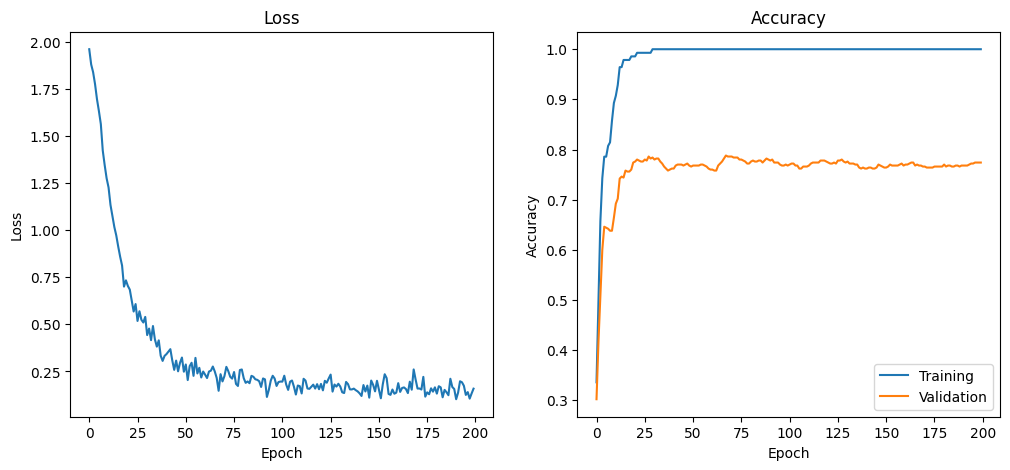

In [ ]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(train_accuracies, label='Training')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
max_val_acc = np.max(val_accuracies)
best_model_test_acc = test_accuracies[np.where(np.asarray(val_accuracies)==max_val_acc)[0][0]]

print('Max Validation Acc: {:.4f}, best model Test acc: {:.4f}'.format(max_val_acc, best_model_test_acc))

Max Validation Acc: 0.7880, best model Test acc: 0.8040


To get an understanding on how the CORA dataset and our model behave, let's also plot the network together with the ground truth and the predictions made.

In [ ]:
from networkx.drawing.nx_agraph import graphviz_layout

def plot_ground_truth_vs_predictions(G, y, pred_y, prog='sfdp', cmap=plt.cm.hsv, node_size=5):
  # Plot the graph
  pos = graphviz_layout(G, prog=prog)

  plt.rc('axes.spines', **{'bottom':False, 'left':False, 'right':False, 'top':False})
  plt.figure(figsize=(16, 8))
  plt.subplot(121)
  nx.draw_networkx_nodes(G, pos, node_color=y, node_size=node_size, cmap=cmap)
  nx.draw_networkx_edges(G, pos, edgelist=G.edges())
  plt.title('Ground truth')
  plt.subplot(122)
  nx.draw_networkx_nodes(G, pos, node_color=pred_y, node_size=node_size, cmap=cmap)
  nx.draw_networkx_edges(G, pos, edgelist=G.edges())
  plt.title('Predicted labels')
  plt.show()
  plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':True, 'top':True})

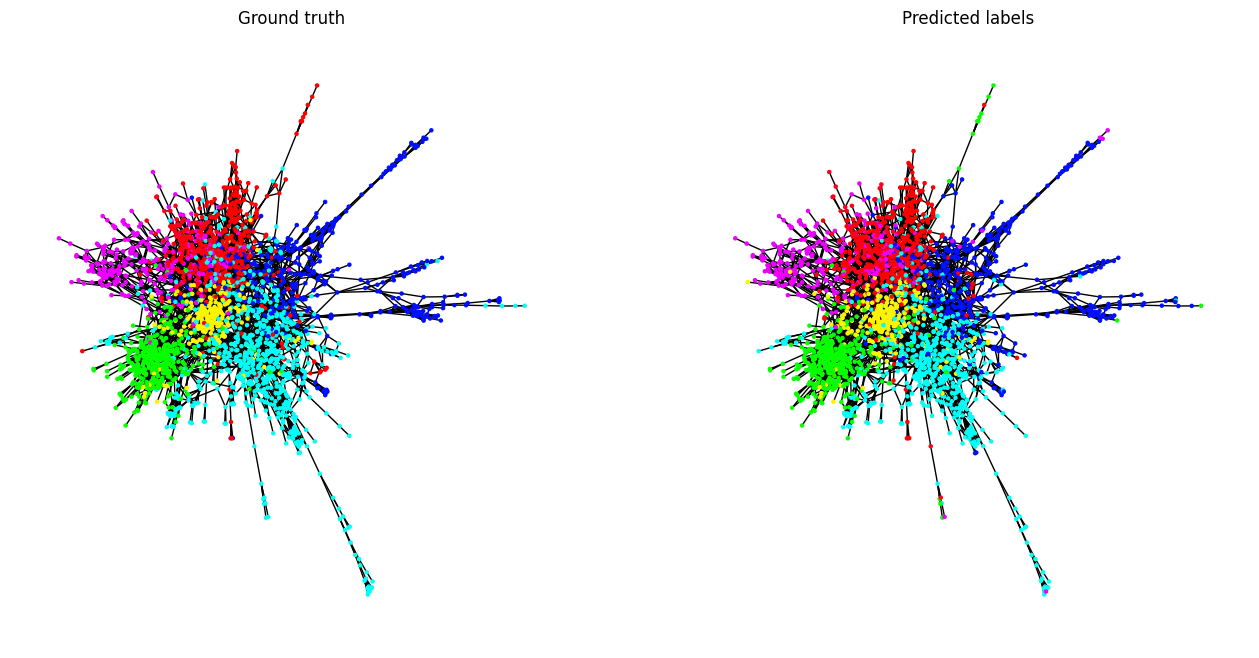

In [ ]:
pred_y = model(data).argmax(dim=1)

# Convert CORA into networkx format and visualizes the largest connected (lcc)
# component with labels and predictions.

G = torch_geometric.utils.to_networkx(data, to_undirected=True)
lcc_idx = np.sort(list(max(nx.connected_components(G), key=len)))
lcc_subgraph = G.subgraph(lcc_idx)
lcc_y = data.y.cpu().numpy()[lcc_idx]
lcc_pred_y = pred_y.cpu().numpy()[lcc_idx]

# Plot the graph
plot_ground_truth_vs_predictions(lcc_subgraph, lcc_y, lcc_pred_y)

As you can see, the model actually makes only a small amount of  mistakes (as expected) and generally captures well the distribution of the classes (which appear to be clustered in the network).

### Custom implementation of GCN layers

In this section of the notebook, we will implement on our own the GCN layer we used above  so that you can get an idea on how diffusion layers implemented in PyG actually work under the hood (please note, in PyG it is possible to implement custom diffusion layers using the `MessagePassing` class, here we are not gonna use that so that you'll have to go through every single step of the implementation).

For our implementation of the GCN diffusion layer, there are two options at our disposal: one that resorts to `sparse-dense` matrix multiplications, and one that resorts to a `gather-scatter` scheme. In this section (and the next one), you will have to implement only the `sparse-dense` approach, which is more natural to understand for GCN (and GAT), and we will move to the `gather-scatter` scheme only for MPNNs.

In the `sparse-dense` matrix multiplication scheme, the idea is to implement the GCN diffusion layer by materializing the adjacency matrix $\mathbf{\tilde{A}}$ as a sparse matrix (which would be computationally more efficient than a dense matrix, especially for large graphs), and project matrix $\mathbf{H}$ on it to propagate information on the domain. The construction of the sparse adjacency matrix relies on the **edge_index** tensor, which defines the graph's connectivity. We provide below the structure of the layer you should implement, together with a routine for testing. Go ahead, and implement the GCN layer on your own.

In [ ]:
class GCNConv_sparse(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.lin = torch.nn.Linear(in_dim, out_dim)
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()

    def forward(self, x, edge_index):
        # hint: use torch.sparse_coo_tensor for constructing the adjacency matrix
        #       (see https://pytorch.org/docs/stable/generated/torch.sparse_coo_tensor.html
        #       if not familiar with this)
        # hint: use torch.spmm for sparse-dense matrix multiplications
        ###### YOUR CODE #######
        A = torch.sparse_coo_tensor(edge_index, torch.ones(edge_index.shape[1]), (x.shape[0], x.shape[0]))
        A = torch.eye(x.shape[0]) + A
        D = torch.sparse.sum(A, dim=1).to_dense()
        D_inv = torch.diag(torch.pow(D, -1/2))
        A_hat = torch.sparse.mm(torch.sparse.mm(D_inv, A), D_inv)
        h = torch.sparse.mm(A_hat, h)
        h = self.lin(x)
        #############

        return h

In [ ]:
# Here we test the implementation of our GCN layer w.r.t. the one provided in PyG.

num_hidden_features = 1
pyg_gcn_layer = GCNConv(data.x.shape[1], num_hidden_features).to(device)
my_gcn_layer = GCNConv_sparse(data.x.shape[1], num_hidden_features).to(device)

# sets weights on both layers to be the same
weight_matrix = torch.rand(pyg_gcn_layer.lin.weight.shape).to(device)
bias = torch.rand(pyg_gcn_layer.bias.shape).to(device)

pyg_gcn_layer.lin.weight.data = weight_matrix
pyg_gcn_layer.bias.data = bias

my_gcn_layer.lin.weight.data = weight_matrix
my_gcn_layer.lin.bias.data = bias

assert torch.allclose(pyg_gcn_layer(data.x, data.edge_index),
                      my_gcn_layer(data.x, data.edge_index))

NotImplementedError: Could not run 'aten::_indices' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::_indices' is only available for these backends: [Meta, SparseCPU, SparseCUDA, SparseMeta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Meta: registered at ../aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
SparseCPU: registered at aten/src/ATen/RegisterSparseCPU.cpp:1406 [kernel]
SparseCUDA: registered at aten/src/ATen/RegisterSparseCUDA.cpp:1576 [kernel]
SparseMeta: registered at aten/src/ATen/RegisterSparseMeta.cpp:290 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at aten/src/ATen/RegisterFunctionalization_2.cpp:23773 [kernel]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: registered at ../torch/csrc/autograd/generated/ADInplaceOrViewType_0.cpp:4942 [kernel]
AutogradOther: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradCPU: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradCUDA: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradHIP: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradXLA: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradMPS: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradIPU: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradXPU: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradHPU: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradVE: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradLazy: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradMTIA: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradPrivateUse1: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradPrivateUse2: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradPrivateUse3: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradMeta: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
AutogradNestedTensor: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16894 [autograd kernel]
Tracer: registered at ../torch/csrc/autograd/generated/TraceType_1.cpp:16106 [kernel]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:321 [backend fallback]
AutocastXPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:463 [backend fallback]
AutocastMPS: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:157 [backend fallback]


### Interpreting GCN layers

Now that we understand how a GCN layer can be implemented, let's try to build an understanding on why it allows to achieve good performance on CORA. As we can see from the above experiment, our GCN succeds at correctly classifying the documents ~80% of the time, despite the very small amount of training samples we used (i.e. 140 over a dataset of ~2.7k nodes, that's roughly 5% of labelled nodes). The reason for this good performance lies in the inductive bias that GCN layers provide to the model. Recall that GCN adds a self-loop to the adjacency matrix, and then realizes a message passing layer that resembles somethig akin a weighted average:

$$
\mathbf{\tilde{h}}_i = \sigma(\sum_{j=1}^n \frac{\widetilde{a}_{ij}}{\sqrt{\widetilde{d}_i \widetilde{d}_j}} \mathbf{W} \mathbf{h}_j), \,\,\, \widetilde{a}_{ij} > 0 \iff (i,j) \in \widetilde{E}
$$

As a result of this, the features of a target node $i$ tend to be smooth out by GCN layers, which in turn favor smooth predictions over the provided graph (which in the case of CORA is great, as nodes of a given class tend to be clustered together!). To verify this is actually the case, we can investigate the value of the **Dirichlet energy** of the output features produced by our GCN (if you are not familiar with the concept of Dirichlet energy on grids, please refer to [link](https://en.wikipedia.org/wiki/Dirichlet_energy)).

For a signal $\mathbf{x}$ defined on the nodes of our graph, the Dirichlet energy is defined as $\mathbf{x}^T \mathbf{\Delta} \mathbf{x}$, where $\mathbf{\Delta}$ is the symmetric normalized Laplacian (defined as $\mathbf{\Delta} = \mathbf{I} - \mathbf{D}^{-\frac{1}{2}}\mathbf{A}\mathbf{D}^{-\frac{1}{2}}$). This is a measure of how "smooth" the signal is on the provided domain, as it corresponds to:

$$\mathbf{x}^T \Delta \mathbf{x} = \sum_{(i, \ j)\in E}\left(\frac{\mathbf{x}_i}{\sqrt{d_i}} - \frac{\mathbf{x}_j}{\sqrt{d_j}}\right)^2;$$

which can be interpreted as the summation of square gradients $\nabla_{ij} = \frac{\mathbf{x}_i}{\sqrt{d_i}} - \frac{\mathbf{x}_j}{\sqrt{d_j}}$, computed over the edges of the provided graph. Values of Dirichlet energy close to $0$ are ones in which the signal is "smooth" over the graph, while the larger the energy becomes the more varied the signal is across neighboring nodes.

\\

Try now implementing a routine that computes the Dirichlet energy of a signal, and verify that repeated projection of a random signal $\mathbf{x}$ on the diffusion operator of GCN (i.e. $\mathbf{\tilde{D}}^{-\frac{1}{2}} \mathbf{\tilde{A}} \mathbf{\tilde{D}}^{-\frac{1}{2}}$) result in decreasing energy values. Use the adjacency matrix of the CORA dataset for this, and renormalize the $\mathbb{L}_2$ norm of $\mathbf{x}$ to be equal to 1 after each projection, to ensure sure that $\mathbf{x}$ is not simply driven to be a zero vector.

In [ ]:
all_dirichlet_energies = []
def dirichlet_energy(x, L):
  ###### YOUR CODE #######
  energy = (x.T @ L @ x).item()
  return energy
  #############

In [ ]:
A = to_dense_adj(data.edge_index)[0].to(device)

x = torch.randn(A.shape[0], 1).to(device)
x = x / torch.linalg.norm(x)

###### YOUR CODE #######
# Here you should implement a code that implements 50 consecutive projections
# of x on GCN diffusion operator (i.e. \tilde{D}^{-0.5}\tilde{A}\tilde{D}^{-0.5})
# and captures the dirichlet energy of the obtained projections in a list named
# `all_dirichlet_energies`.
# Compute the degree matrix
degrees = torch.sum(A, dim=1)
D_inv_sqrt = torch.diag(torch.pow(degrees, -0.5))  # D^{-0.5}

# Normalized adjacency matrix
A_tilde = D_inv_sqrt @ A @ D_inv_sqrt  # \tilde{A} = D^{-0.5} A D^{-0.5}

# Symmetric normalized Laplacian
L = torch.eye(A.shape[0], device=A.device) - A_tilde  # \Delta = I - \tilde{A}

for i in range(50):
    energy = dirichlet_energy(x, L)
    all_dirichlet_energies.append(energy)

    # Project x on the diffusion operator
    x = torch.matmul(A_tilde, x)

    # Renormalize x to unit norm (L2 norm = 1)
    x = x / torch.linalg.norm(x)
#############

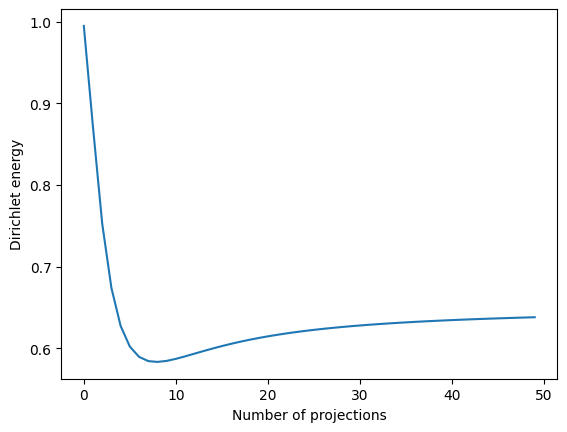

In [ ]:
plt.figure()
plt.plot(all_dirichlet_energies)
plt.xlabel('Number of projections')
_ = plt.ylabel('Dirichlet energy')

If your implementation is correct, you should obtain a Dirichlet energy of the provided input signal that monotonically decreases w.r.t. the number of projections we did on the GCN diffusion operator (which confirms our intuition that GCN layers implicitly smooth out the provided input signal). As we mentioned above, this particular inductive bias can be a good thing and favor generalization on datasets like CORA where nodes with same labels are clustered together, however we should also note that it can be a limitation on datasets where this might not be the case (i.e. on heterophilic datasets).

## Section 3: Graph Attention Networks

While our simple GNN implemented with GCN layers is able to achieve good performance on CORA, it is natural to wonder whether we can do even better by refining the diffusion layer further. One interesting limitation that we can observe from GCN is that the weight that each neighbor receives in the propagation step is fixed a priori, and depends only on the structure of the graph. In principle, this is not necessarily the best thing to do for maximizing performance, as such weights are not necessarily optimized for the task at hand. Following this intuition, Monti et al. (https://arxiv.org/abs/1611.08402), and several researchers after them, proposed to realize diffusion layers that have the ability of directly learning **from the data** the **importance** that each neighbor should receive in the aggregation process. In formula, layers implementing such **attention mechanisms** can be generally defined as:

$$\mathbf{\tilde{H}} = \sigma \big( \mathbf{\hat{A}}(\mathbf{H}) \mathbf{H} \mathbf{W}\big);$$

where $\mathbf{\hat{A}}(\mathbf{H})_{i,j} = a(\mathbf{h}_i, \mathbf{h}_j)$ for $(i,j) \in E$, $\mathbf{\hat{A}}(\mathbf{H})_{i,j} = 0$ for $(i,j) \notin E$, and $a(., .): \mathbb{R}^k \times \mathbb{R}^k \rightarrow \mathbb{R}$ is a function predicting the attention scores (which can be followed by a normalization layer to make such scores sum up to one for a target node). Of all possible variations of attention-based GNNs, in this section we will focus on `Graph Attention Network (GAT)` (https://arxiv.org/abs/1710.10903), due to its simplicity and good performance it allows to achieve on the CORA dataset. Let $\|$ be the concatenation operator, a single-head graph attention layer can be defined as:

$$\mathbf{\tilde{h}}_i = \sigma \big( \sum_{j \in N_i \cup \{i\}} \alpha_{i,j} \mathbf{W}\mathbf{h}_j \big);$$

where:

$$\alpha_{i,j} = \frac{e^{LeakyReLU\big(\mathbf{a}^T(\mathbf{W}\mathbf{h}_i \| \mathbf{W}\mathbf{h}_j)\big)}}{\sum_{k \in N_i \cup \{i\}} e^{LeakyReLU\big(\mathbf{a}^T(\mathbf{W}\mathbf{h}_i \| \mathbf{W}\mathbf{h}_k)\big)}}.$$

If multiple attention heads are used instead, the formula simply changes to:

$$\mathbf{\tilde{h}}_i = \|_k \sigma \big( \sum_{j \in N_i \cup \{i\}} \alpha_{i,j}^{(k)} \mathbf{W}^{(k)}\mathbf{h}_j \big).$$

Let's now try to implement a 2-layer GNN with graph attention and PyG. For the sake of this experiment we will replicate the architecture used in `GAT`.

In [ ]:
from torch_geometric.nn import GATConv

In [ ]:
# Class implementing our GCN model
class GAT(torch.nn.Module):
    def __init__(self, num_input_features, list_num_features, list_num_heads, dropout_p=0.7, non_linearity=lambda x: F.elu(x)):
        super().__init__()
        self.dropout_p = dropout_p
        self.conv_layers = []
        for idx_layer, num_features in enumerate(list_num_features):
          if idx_layer == 0:
            self.conv_layers.append(GATConv(num_input_features,
                                            num_features,
                                            heads=list_num_heads[idx_layer],
                                            dropout=dropout_p))
          else:
            self.conv_layers.append(GATConv(list_num_features[idx_layer-1]*list_num_heads[idx_layer-1],
                                            num_features,
                                            heads=list_num_heads[idx_layer],
                                            dropout=dropout_p))
        self.conv_layers = torch.nn.ModuleList(self.conv_layers)
        self.non_linearity = non_linearity

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for idx_layer, conv_layer in enumerate(self.conv_layers):
          x = F.dropout(x, training=self.training, p=self.dropout_p)
          x = conv_layer(x, edge_index)
          if idx_layer < len(self.conv_layers)-1:
            x = self.non_linearity(x)

        return x

In [ ]:
# Specify training parameters
lr = 1e-2
weight_decay = 5e-4
num_epochs = 200
list_num_features = [8, num_classes]
list_num_heads = [8, 1]

# Initialize the model
torch.manual_seed(42)  # Setting a random seed
model = GAT(num_features, list_num_features, list_num_heads).to(device)

# Set up optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Define training loss
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluate the model
losses, train_accuracies, val_accuracies, test_accuracies = train_and_eval_single_graph(model, data, optimizer, criterion, num_epochs)

In [ ]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
max_val_acc = np.max(val_accuracies)
best_model_test_acc = test_accuracies[np.where(np.asarray(val_accuracies)==max_val_acc)[0][0]]

print('Max Validation Acc: {:.4f}, best model Test acc: {:.4f}'.format(max_val_acc, best_model_test_acc))

As we can see, the model performs even better than GCN, and achieves a test accuracy equal to 82.50%.

### Custom implementation of GAT layers

As we did for the GCN layer, let's now try to implement a custom GAT layer so that we can get a better understanding on how it would work. Go ahead and implement now your own version of GAT, using again `sparse-dense` matrix multiplications. For the sake of simplicity, ignore any application of dropout here. We provide below the code for testing your implementation to check that it is correct.

To reproduce the PyG implementation make sure that you compute the attention scores applying self.att_dst and self.att_src on respectively the features of the target node, and the features of the neighbors obtained after the application of an initial dense layer (which we provide to guide you towards the same PyG implementation).

In [ ]:
class GATConv_sparse(torch.nn.Module):
    def __init__(self, in_dim, out_dim, num_heads=1):
        super().__init__()

        self.num_heads = num_heads
        self.out_dim = out_dim

        self.lin = torch.nn.Linear(in_dim, out_dim*num_heads)
        # attention coefficients for the neighbor of the target node
        self.att_src = torch.nn.Parameter(torch.randn(1, num_heads, out_dim))
        # attention coefficients for the target node
        self.att_dst = torch.nn.Parameter(torch.randn(1, num_heads, out_dim))

        self.leaky_relu = torch.nn.LeakyReLU(negative_slope=0.2)
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()

    def forward(self, x, edge_index):
        # hint: use torch.sparse.softmax for normalizing the weights here.
        # hint: use torch_geometric.utils.remove_self_loops and
        #   use torch_geometric.utils.add_self_loops for making sure every node
        #   has a self-loop in edge_index.
        # hint: to reproduce the PyG implementation consider the nodes specified in
        #   edge_index[1] as target node and the ones specified in edge_index[0]
        #   as the neighbor.

        h = self.lin(x).view(-1, self.num_heads, self.out_dim) # application of initial dense layer

        ###### YOUR CODE #######

        #############

        return all_h

In [ ]:
# Here we test the implementation of our GAT layer w.r.t. the one provided in PyG.

num_hidden_features = 1
num_heads = 8
pyg_gat_layer = GATConv(data.x.shape[1], num_hidden_features, heads=num_heads).to(device)
my_gat_layer = GATConv_sparse(data.x.shape[1], num_hidden_features, num_heads=num_heads).to(device)

# sets weights on both layers to be the same
weight_matrix = torch.rand(pyg_gat_layer.lin.weight.shape).to(device)
bias = torch.zeros(pyg_gat_layer.bias.shape).to(device)

att_params_src = torch.randn(1, num_heads, num_hidden_features).to(device)
att_params_dst = torch.randn(1, num_heads, num_hidden_features).to(device)

pyg_gat_layer.lin.weight.data = weight_matrix
pyg_gat_layer.bias.data = bias
pyg_gat_layer.att_src.data = att_params_src
pyg_gat_layer.att_dst.data = att_params_dst

my_gat_layer.lin.weight.data = weight_matrix
my_gat_layer.lin.bias.data = bias
my_gat_layer.att_src.data = att_params_src
my_gat_layer.att_dst.data = att_params_dst

assert torch.allclose(pyg_gat_layer(data.x, data.edge_index),
                      my_gat_layer(data.x, data.edge_index))

## Section 4: MPNNs and graph-property prediction tasks

The final variation of diffusion layers that we dive into in this notebook is what is generally called `message-passing` layer. Message-passing layers are an extremely general way of implementing permutation equivariant functions on graphs, and many other diffusion layers fall, as a result, as a particular case of these. In formula, a message-passing layer can be defined as:

$$\mathbf{\tilde{h}}_i = \phi\big(\mathbf{h}_i, \oplus_{j \in N_i} \psi(\mathbf{h}_i, \mathbf{h}_j, \mathbf{e}_{i,j})\big);$$

where $\mathbf{e}_{i,j}$ are the features of the edge between $i$ and $j$, $\psi(., ., .): \mathbb{R}^k \times \mathbb{R}^k \times \mathbb{R}^{k_e} \rightarrow \mathbb{R}^{k'}$ is a `message function` that determines what kind of information shall be sent from neighbor $j$ to target node $i$, $\oplus$ is a permutation invariant operator (e.g. sum, mean, max, ...), and $\phi(., .): \mathbb{R}^k \times \mathbb{R}^{k'} \rightarrow \mathbb{R}^{k''}$ is an `update function` that refines the features of target node $i$ based on their value and the aggregated descriptor obtained from $\oplus_{j \in N_i} \psi(\mathbf{h}_i, \mathbf{h}_j, \mathbf{e}_{i,j})$.

To make you experiment with a different prediction task w.r.t. what we faced in the previous sections, we will resort to the ZINC dataset in this part of the notebook. ZINC contains ~12,000 molecular graphs with up to 38 nodes each and the task is to predict for each molecule its solubility. The task is thus a graph-level prediction problem, and in particular it corresponds to graph regression (since the solubility of a molecule is a continuous value).

First of all, let's load the dataset using the [torch_geometric.dataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.ZINC) and let's check what it contains:

In [ ]:
from torch_geometric.datasets import ZINC

In [ ]:
from networkx.drawing.nx_agraph import graphviz_layout

train_zinc_dataset = ZINC(root='tmp/ZINC', split='train', subset=True)
val_zinc_dataset = ZINC(root='tmp/ZINC', split='val', subset=True)
test_zinc_dataset = ZINC(root='tmp/ZINC', split='test', subset=True)

print(f"\nTrain examples: {len(train_zinc_dataset)}")
print(f"Val examples: {len(val_zinc_dataset)}")
print(f"Test examples: {len(test_zinc_dataset)}\n")

print("Some statistics:\n")
for k in range(10):
  one_graph = train_zinc_dataset[k]
  print(f"Graph {k} contains {one_graph.x.shape[0]} nodes, and {one_graph.edge_index.shape[1]} edsges. Each node is characterised by {one_graph.x.shape[1]} features (of type {one_graph.x.dtype}), and we need to predict {one_graph.y.shape[0]} features (of type {one_graph.y.dtype}).")

print("\nNetworkx visualizations:\n")

plt.rc('axes.spines', **{'bottom':False, 'left':False, 'right':False, 'top':False})
plt.figure(figsize=(16, 8))
for k in range(9):
  one_graph = train_zinc_dataset[k]
  G = torch_geometric.utils.to_networkx(one_graph, to_undirected=True)

  plt.subplot(3, 3, k+1)
  pos = graphviz_layout(G, prog='sfdp')
  nx.draw_networkx_nodes(G, pos, node_size=5)
  nx.draw_networkx_edges(G, pos, edgelist=G.edges())

As we we can see, all graphs have different number of nodes and edges in our dataset (which is expected as they describe different molecules - the feature associated to each node is indeed the atom type here). Since we are interested in predicting graph-level properties, feeding our GNN with one graph at a time might result in noisy gradients at training time, which might slow down the learning process. To improve convergence, we need to construct mini-batches of graphs. If we take some inspiration from Computer Vision, when dealing with images, mini-batches are typically constructed by directly stacking together multiple samples (as these all have the same size). However, graphs in the ZINC dataset have different number of nodes and edges, so how can we batch them together? To make things efficient, a common solution is to construct a single big graph of k-disconnected components, which can be simply obtained stacking over the diagonal the adjacency matrices of different graphs and concatenate the provided node features.


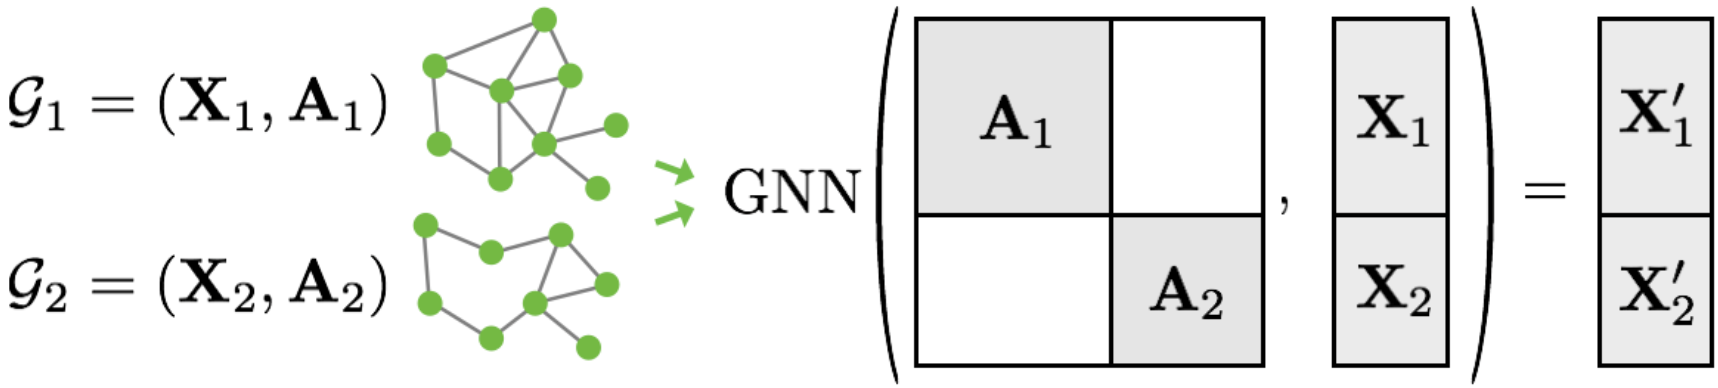

                                                [Picture from PyG documentation]

To do this in PyG, we can simply resort to `torch_geometric.data.DataLoader`, which implements exactly the aforementioned behavior.

In [ ]:
from torch_geometric.loader import DataLoader

tmp_loader = DataLoader(train_zinc_dataset[:3], batch_size=3, shuffle=False)

for step, data in enumerate(tmp_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

    plt.figure()
    plt.imshow(to_dense_adj(data.edge_index)[0])
    plt.colorbar()

Now that we know how to construct mini-batches for graph-structured data, a natural question one might have is how to summarize the information contained in the different nodes of a graph in a single graph-wise prediction. A common solution for this is to apply a global pooling layer (e.g. a layer computing the sum of all node embeddings, their average, or their channel-wise maximum) to the features of the last diffusion layer, followed by a MLP:

$$\hat{y} = \eta\big(\oplus_i \mathbf{h}^{(L)}_i\big).$$

Provided that all layers that preceed the global pooling operation are permutation-equivariant, this ensures that the overall model is permutation invariant by construction (which, remember, is a desired property as the order of nodes is arbitrary in our adjacency matrices / matrices of node features).

Let's now try to build a simple solution for predicting the solubility of our molecules in ZINC.

First of all, we need to implement out desired message-passing layer. Differently from what we did in the previous sections of this notebook, we will resort here to the `gather-scatter` scheme, as it provides a natural way for implementing the message-passing formalism.

In the `gather` phase of our layer, we will construct all the messages that need to be exchanged between nodes, while in the `scatter` phase we will aggregate them together to produce the desired neighborhood descriptors. Now, go ahead and implement your own message passing layer, and a simple GNN leveraging your implementation. Use `torch_scatter.scatter` for aggregating information coming from multiple neighbors. For the sake of simplicity, use a single dense layer (followed by ReLU) to implement $\psi(\ldots)$ (which should be applied on the concatenation of $\mathbf{h}_i$ and $\mathbf{h}_j$), and a single dense layer (applied on the concatenation of $\mathbf{h}_i$ and $\oplus_{j \in N_i} \psi(\mathbf{h}_i, \mathbf{h}_j, \mathbf{e}_{i,j})$) to implement $\phi(\ldots)$.

For what concerns the structure of the GNN, use 4 diffusion layers, where all layers produce 64 output features from $\psi(\ldots)$, and all layers but the last one output 64 features from $\phi(\ldots)$. The last layer should produce only one feature from $\phi(\ldots)$, as this is the solubility of the given molecule. Apply a global pooling layer implementing the summation operation (use `torch_geometric.nn.pool.global_add_pool` for this) on top of the last diffusion layer to produce the final graph-wise prediction.

As the input features in ZINC are categorical (as they represent the types of atoms we can have), we will also learn 64-dimensional node representations for these (you can use `torch.nn.Embedding` for obtaining a learnable vector of weights for each atom type). ReLU should be the non-linearity of choice throughout the entire network. For training, build mini-batches of 128 graphs, use Adam as optimizer, train for 30 epochs and use a learning rate equal to 1e-3, weight decay equal to 0., no dropout, and use Mean Square Error as both a loss function and an evaluation metric.

With a properly implemented model you should obtain something akin to a test MSE ~0.8.

In [ ]:
class MPNN_gather_scatter(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, non_linearity=lambda x: F.relu(x)):
        super().__init__()
        self.lin_1 = torch.nn.Linear(in_dim*2, hidden_dim)
        self.lin_2 = torch.nn.Linear(in_dim + hidden_dim, out_dim)
        self.non_linearity = non_linearity

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_1.reset_parameters()
        self.lin_2.reset_parameters()

    def forward(self, x, edge_index):
        ###### YOUR CODE #######

        #############

        return h

In [ ]:
# Class implementing our GNN model
class MPNN(torch.nn.Module):
    def __init__(self, num_input_features, list_num_features, non_linearity=lambda x: F.relu(x), num_atoms=28):
        super().__init__()
        # num_input_features is here the number of features to be used in torch.nn.Embedding
        # list_num_features is here a list of tuples, where the first entry in the i-th tuple is the number of output
        #     features of \psi in the i-th layer, and the second is the number of output featurds of \phi in the
        #     i-th layer.

        ###### YOUR CODE #######

        #############

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # hint: here batch contains the index of the graph each node belongs to
        #       in the given batch (to be used with torch_geometric.nn.pool.global_add_pool)

        ###### YOUR CODE #######

        #############

In [ ]:
def evaluate_model(model, eval_loader, criterion, device):
  model.eval()
  eval_loss = 0.
  for step, data in enumerate(eval_loader):
    data = data.to(device)
    out = model(data)
    loss = criterion(out, data.y)
    eval_loss += loss.item()

  return eval_loss / len(eval_loader)

In [ ]:
# Batch the dataset
batch_size=128

train_loader = DataLoader(train_zinc_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_zinc_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_zinc_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Specify training parameters
lr = 1e-3
num_epochs = 30
num_features = 64
list_num_features = [(64, 64), (64, 64), (64, 64), (64, 1)]
weight_decay = 0.

# Initialize the model
torch.manual_seed(42)  # Setting a random seed
model = MPNN(num_features, list_num_features).to(device)

# Set up optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Define training loss
criterion = torch.nn.MSELoss()

In [ ]:
# Training loop
train_MSEs = []
val_MSEs = []
test_MSEs = []
for epoch in range(30):
    ############### Training step ###############

    # Forward pass with dropout
    model.train()

    train_MSE = 0.
    for step, data in enumerate(train_loader):
      data = data.to(device)
      # Clean gradients
      optimizer.zero_grad()

      out = model(data)
      loss = criterion(out, data.y)

      # Backpropagation step
      loss.backward()
      optimizer.step()

      train_MSE += loss.item()

    train_MSE = train_MSE / len(train_loader)

    ############### Model evaluation after training step ###############

    # Forward pass without dropout
    val_MSE = evaluate_model(model, val_loader, criterion, device)
    test_MSE = evaluate_model(model, test_loader, criterion, device)

    train_MSEs.append(train_MSE)
    val_MSEs.append(val_MSE)
    test_MSEs.append(test_MSE)

    print('Epoch: {}, Training MSE: {:.4f}, Validation MSE: {:.4f}'.format(epoch+1, train_MSE, val_MSE))

In [ ]:
min_val_MSE = np.min(val_MSEs)
best_model_test_MSE = test_MSEs[np.where(np.asarray(val_MSEs)==min_val_MSE)[0][0]]

print('Min Validation MSE: {:.4f}, best model Test MSE: {:.4f}'.format(min_val_MSE, best_model_test_MSE))

### [Optional] GCN on heterophilic datasets

Earlier in the notebook we mentioned that using GCN on heterophilic dataset (i.e. where nodes of different classes tend to be connected to each other) can be problematic, let's verify this with an example. We'll try now implementing a simple GCN on the roman-empire dataset (which is a dataset showing indeed heterophily).

First of all, let's load the dataset in memory, and visualize it using networkx.

In [ ]:
from torch_geometric.datasets import HeterophilousGraphDataset

dataset_roman = HeterophilousGraphDataset(root='tmp/Roman', name='Roman-empire')

print("Number of graphs: ", len(dataset_roman))
print("Number of features: ", dataset_roman.num_features)
print("Number of classes: ", dataset_roman.num_classes)

# select the first split of the dataset
data_roman = dataset_roman[0]

data_roman.train_mask = data_roman.train_mask[:, 0]
data_roman.val_mask = data_roman.val_mask[:, 0]
data_roman.test_mask = data_roman.test_mask[:, 0]

print("\nNumber of nodes: ", data_roman.num_nodes)
print("Number of edges: ", data_roman.num_edges)
print("Is directed: ", data_roman.is_directed())

print("\nNumber of training nodes", data_roman.train_mask.sum().numpy())
print("Number of validation nodes", data_roman.val_mask.sum().numpy())
print("Number of test nodes", data_roman.test_mask.sum().numpy())

data_roman = data_roman.to(device)
num_features_roman = data_roman.num_features
num_classes_roman = dataset_roman.num_classes  # Ensure dataset provides num_classes

In [ ]:
from networkx.drawing.nx_agraph import graphviz_layout

# Convert Roman-empire into networkx format
G = torch_geometric.utils.to_networkx(data_roman, to_undirected=True)

# Plot the graph
pos = graphviz_layout(G, prog='sfdp')
cmap = plt.cm.hsv
plt.rc('axes.spines', **{'bottom':False, 'left':False, 'right':False, 'top':False})
plt.figure(figsize=(16, 8))
nx.draw_networkx_nodes(G, pos,
                       node_color=data_roman.y.cpu().numpy(), node_size=5,
                       cmap=cmap)
nx.draw_networkx_edges(G, pos,
                       edgelist=G.edges())
plt.title('Ground truth')
plt.show()
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':True, 'top':True})

As we can see, the dataset looks like a chain, and we have a constant fluctuation of classes from one node to the other. Let's now implement a GNN that like for CORA aims at classifying the different nodes in the graph. How does a GNN implemented only with GCN layers perform on this dataset? What happens to performance when we add a residual connection in every layer? Why?

In [ ]:
# Class implementing our GCN model
class GCN_Roman(torch.nn.Module):
    def __init__(self, num_input_features, list_num_hidden_features, num_classes, use_residual=False):
        super().__init__()
        self.red_layer = torch.nn.Linear(num_input_features, list_num_hidden_features[0])
        self.conv_layers = []
        for idx_layer, num_hidden_features in enumerate(list_num_hidden_features):
          if idx_layer == 0:
            self.conv_layers.append(GCNConv(list_num_hidden_features[0],
                                            num_hidden_features))
          else:
            self.conv_layers.append(GCNConv(list_num_hidden_features[idx_layer-1],
                                            list_num_hidden_features[idx_layer]))
        self.class_layer = torch.nn.Linear(list_num_hidden_features[-1], num_classes)
        self.conv_layers = torch.nn.ModuleList(self.conv_layers)
        self.use_residual = use_residual

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # here we make a first reduction step to enable using residual connections right away with the first layer
        x = self.red_layer(x)
        for idx_layer, conv_layer in enumerate(self.conv_layers):
          ###### YOUR CODE #######
          # hint: implement here a diffusion layers using GCN or GCN
          #        with a residual connection dependently on the value of
          #        self.use_residual. Always apply ReLU on the final output
          #        produced by your code.

          #############

        # here we predict the logits of the different classes
        x = self.class_layer(x)

        return x

In [ ]:
# Specify training parameters
lr = 1e-2
weight_decay = 0
list_num_hidden_features = [16, 16]
num_epochs = 5000

# Define training loss
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
stats_dict = dict()
for use_residual in [True, False]:
  # Initialize the model
  torch.manual_seed(42)  # Setting a random seed
  model = GCN_Roman(num_features_roman, list_num_hidden_features, num_classes_roman,
                    use_residual=use_residual).to(device)

  # Set up optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  # Train and evaluate the model
  losses, train_accuracies, val_accuracies, test_accuracies = train_and_eval_single_graph(model, data_roman, optimizer, criterion, num_epochs, verbose=False)

  if use_residual:
    label = 'GCN w/ Residual'
  else:
    label = 'GCN w/o Residual'
  stats_dict[label] = (losses, train_accuracies, val_accuracies, test_accuracies)

print('Done with training the models!')

In [ ]:
# Plot the loss and accuracy
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
for label in stats_dict.keys():
  plt.plot(stats_dict[label][0], label=label)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
for label in stats_dict.keys():
  plt.plot(stats_dict[label][1], label=label)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
for label in stats_dict.keys():
  plt.plot(stats_dict[label][2], label=label)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
for label in stats_dict.keys():
  max_val_acc = np.max(stats_dict[label][2])
  best_model_test_acc = stats_dict[label][3][np.where(np.asarray(stats_dict[label][2])==max_val_acc)[0][0]]

  print('{:s}: Max Validation Acc: {:.4f}, best model Test acc: {:.4f}'.format(label, max_val_acc, best_model_test_acc))